In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

import random
import os
import cv2
from sklearn.metrics import roc_curve, auc


import sys
sys.path.append('../scripts')
from utils import *

#data from here http://weegee.vision.ucmerced.edu/datasets/landuse.html

In [2]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1)

def get_curves(labels, n_out: int, trials: list = [0], pca_type: str = 'pca', base_dir: str = 'results', fl_type: str = ''):
    if len(fl_type) > 0:
        fl_type = f'{fl_type}_'

    fprs = []
    tprs = []
    for trial in trials:
        pca_preds = np.load(f'./{base_dir}/{pca_type}/preds_{fl_type}{n_out}_t{trial}.npy')

        fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
        fprs.append(fpr)
        tprs.append(tpr)

    fpr = tolerant_mean(fprs)
    tpr = tolerant_mean(tprs)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

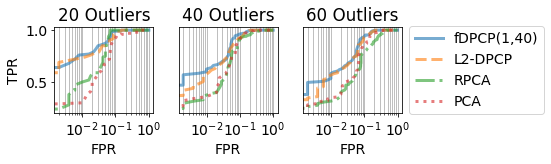

In [13]:

linestyles = ['solid', 'dashed',  'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1, 1, 1))]
res = pd.DataFrame(columns = ['Num Outliers', 'Algorithm', 'AUC'])


base_dir_path = 'results'

trials = [0,1,2,3,4]
face_num = 1

n_in = 100
fl_types = [[1,10]]
fl_ids = ['(1,10)']

dfl_ids = ['(1,40)']

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,3, figsize = (8,2.5))
jj=0
for n_out in [20,40,60]: 
    labels = [0]*n_in + [1]*n_out  

    axs[jj].set_title(f'{n_out} Outliers')

    ii=0
    
    for fl_type, fl_id in zip(fl_types, dfl_ids):
        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'dpcp', fl_type = fl_type, base_dir = base_dir_path)
        axs[jj].plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'fDPCP{fl_id}', alpha = .6)# (AUC = {np.round(roc_auc,2)})')    
        row = pd.DataFrame(columns = res.columns, data = [[n_out, f'DPCP{fl_type}', roc_auc]])
        res = pd.concat([res, row])    
        ii+=1


    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'dpcp_base', base_dir = base_dir_path)
    axs[jj].plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'L2-DPCP', alpha = .6)# (AUC = {np.round(roc_auc,2)})')
    row = pd.DataFrame(columns = res.columns, data = [[n_out, f'L2-DPCP', roc_auc]])
    res = pd.concat([res, row])    
    ii+=1

    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'rpca_base_new', base_dir = base_dir_path)
    axs[jj].plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'RPCA', alpha = .6)# (AUC = {np.round(roc_auc,2)})')
    row = pd.DataFrame(columns = res.columns, data = [[n_out, f'RPCA', roc_auc]])
    res = pd.concat([res, row])    
    ii+=1


    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'pca', base_dir = base_dir_path)
    axs[jj].plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'PCA', alpha = .6)# (AUC = {np.round(roc_auc,2)})')
    row = pd.DataFrame(columns = res.columns, data = [[n_out, 'PCA', roc_auc]])
    res = pd.concat([res, row])    
    ii+=1

 
    
    axs[jj].set_xlabel('FPR')


    axs[jj].set_ylim([.2,1.03])

    axs[jj].set_xscale('log')

    if jj > 0:
        axs[jj].set_yticks([])
    

    axs[jj].grid(True, which="both", axis = 'x')

    


    jj+=1

axs[0].set_ylabel('TPR')

axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()
plt.savefig('../Results/landuse_roc.pdf')